# Lung Disease Diagnosis - Model Tuning

Developer: Tung Nguyen

This notebook is a continuation of model-tuning-1.ipynb and experiments with larger deep learning architectures for the [lung disease diagnosis dataset](https://www.kaggle.com/datasets/nih-chest-xrays/data).

The best performing models from model-tuning-1.ipynb were model-1 (baseline), model-2 (untrained weights), and model-3 ('stratified' sampling - minority classes are sampled with replacement to combat class imbalance).

This notebook attempts to scale up and trains an Xception and DenseNet169 model.Due to resource constraints (training locally), model-2 (training from scratch) will not be pursued for these larger models.
<br>
<br>

__MODEL SUMMARY TABLE__
|  | 8 | 9 | 10 | 11 | 12 |
| --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | Weighted BCE |
| Base Model | Xception | Xception | DenseNet169 | DenseNet169 | DenseNet169 |
| Model Weights | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Stratified Sampling | Random | Stratified Sampling | Random | Random |
| Blocks Frozen | Default | Default | Default | Default | Default |
| Pooling Operation | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D |

* BCE = Binary Cross Entropy

## Data Prep
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow import cast, float32

from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../chest-x-ray-data/Data_Entry_2017.csv')
df = df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=False)

mlb = MultiLabelBinarizer()
lbl_bins = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_bin = df.join(pd.DataFrame(lbl_bins, columns=mlb.classes_))

with open('../chest-x-ray-data/train_val_list.txt', 'r') as f:
    train_list = f.read().split('\n')

with open('../chest-x-ray-data/test_list.txt', 'r') as f:
    test_list = f.read().split('\n')

df_train_val = df_bin[df_bin['Image Index'].isin(train_list)]
df_test = df_bin[df_bin['Image Index'].isin(test_list)]

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=1)

In [3]:
def plot_df_freq(df, labels, title=''):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');
    ax.bar_label(ax.containers[0])
    
    return df_pos

### Data Sampling

In [4]:
# Random Sampling
sampled_df_train = df_train.sample(20000, random_state=1)

sampled_df_val = df_val.sample(2000, random_state=1)

In [5]:
# Stratified Sampling for Data Augmentation
stratified_sampled_df_train = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in mlb.classes_:
    temp = df_train[df_train[lbl] == 1].sample(
        n,
        replace=True,
        random_state=1
    )
    
    stratified_sampled_df_train = pd.concat([stratified_sampled_df_train, temp])

### Weighted Loss

In [6]:
labels = [lbl for lbl in mlb.classes_ if lbl != 'No Finding']

In [7]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=sampled_df_train[lbl]))))
    
# Class Weights
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1])
    neg = np.append(neg, d[0])

In [8]:
def get_weighted_loss(pos, neg, eps=1e-7):
    def weighted_loss(y_true, y_pred):

        # Cast y_true as float for calculations
        y_true = cast(y_true, float32)

        # Initialize loss
        loss = 0.0

        # Calculate weighted binary cross entropy loss
        for i in range(len(pos)):
            loss += -1 * K.mean(pos[i] * y_true[:, i] * K.log(y_pred[:, i] + eps))
            loss += -1 * K.mean(neg[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + eps))

        return loss
    return weighted_loss

### Helper Functions

In [9]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

In [10]:
def datagen_from_df(df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), shuffle=False, batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.05,
        width_shift_range=0.1,
        rotation_range=5,
        shear_range=0.1,
        fill_mode='reflect',
        zoom_range=0.15,
    )

    img_generator = datagen.flow_from_dataframe(
        df,
        data_dir,
        shuffle=shuffle,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )

    return img_generator

In [11]:
# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.00001
)

chkpt = {}    
base_path = './models/'

for i in np.arange(8, 14):

    chkpt[i] = ModelCheckpoint(
        base_path + 'model-' + str(i) + '.h5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, 
        mode='min', 
    )

## Models
---

### DataGenerators

In [15]:
data_dir = '../chest-x-ray-data/imgs/'

In [16]:
train_gen = {}
val_gen = {}

for i in [8, 9]:
    val_gen[i] = datagen_from_df(
        sampled_df_val, 
        x_col = 'Image Index', 
        y_cols = labels, 
        data_dir = data_dir, 
        preproc_func = preprocess_input_Xception, 
        target_size = (256, 256), 
        shuffle=False,
        batch_size = 64, 
        color_mode = 'rgb', 
        random_state = 1
        )

for i in [10, 11, 12]:
    val_gen[i] = datagen_from_df(
        sampled_df_val, 
        x_col = 'Image Index', 
        y_cols = labels, 
        data_dir = data_dir, 
        preproc_func = preprocess_input_densenet, 
        target_size = (256, 256), 
        shuffle=False,
        batch_size = 64, 
        color_mode = 'rgb', 
        random_state = 1
        )

# Xception models
train_gen[8] = datagen_from_df(
    stratified_sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[9] = datagen_from_df(
    sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

# DenseNet models
train_gen[10] = datagen_from_df(
    stratified_sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_densenet, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[11] = datagen_from_df(
    sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_densenet, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[12] = datagen_from_df(
    sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_densenet, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 22500 validated image filenames.
Found 20000 validated image filenames.
Found 22500 validated image filenames.
Found 20000 validated image filenames.
Found 20000 validated image filenames.


In [17]:
history = {}

### Model 8

In [36]:
# Base Models
base_model_Xc_1 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_Xc_1 = Dense(len(labels), activation='sigmoid')(base_model_Xc_1.output)
model_Xc_1 = Model(base_model_Xc_1.input, output_layer_Xc_1)

for layer in model_Xc_1.layers:
    layer.trainable = True

In [37]:
model_Xc_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [38]:
m = 8

history[m] = model_Xc_1.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-05 20:10:58.560822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - ETA: 0s - loss: 0.3368 - auc_2: 0.3057 - auc_3: 0.7175

2022-06-05 20:18:41.934388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.22133, saving model to ./models/model-8.h5
352/352 [==============================] - 498s 1s/step - loss: 0.3368 - auc_2: 0.3057 - auc_3: 0.7175 - val_loss: 0.2213 - val_auc_2: 0.2032 - val_auc_3: 0.7545 - lr: 0.0010
Epoch 2/40
352/352 [==============================] - ETA: 0s - loss: 0.2957 - auc_2: 0.4411 - auc_3: 0.8011
Epoch 2: val_loss improved from 0.22133 to 0.17927, saving model to ./models/model-8.h5
352/352 [==============================] - 464s 1s/step - loss: 0.2957 - auc_2: 0.4411 - auc_3: 0.8011 - val_loss: 0.1793 - val_auc_2: 0.1857 - val_auc_3: 0.7719 - lr: 0.0010
Epoch 3/40
352/352 [==============================] - ETA: 0s - loss: 0.2743 - auc_2: 0.5133 - auc_3: 0.8358
Epoch 3: val_loss did not improve from 0.17927
352/352 [==============================] - 465s 1s/step - loss: 0.2743 - auc_2: 0.5133 - auc_3: 0.8358 - val_loss: 0.2090 - val_auc_2: 0.1942 - val_auc_3: 0.7682 - lr: 0.0010
Epoch 4/40
352/352 [=================

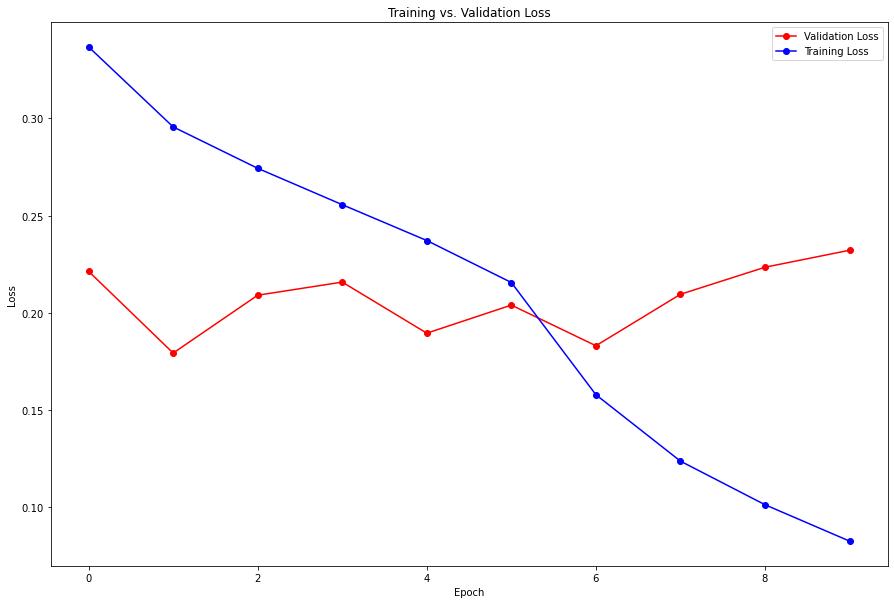

In [39]:
plot_losses(history[m])

### Model 9

In [40]:
# Base Models
base_model_Xc_2 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_Xc_2 = Dense(len(labels), activation='sigmoid')(base_model_Xc_2.output)
model_Xc_2 = Model(base_model_Xc_2.input, output_layer_Xc_2)

for layer in model_Xc_2.layers:
    layer.trainable = True

In [41]:
model_Xc_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [42]:
m = 9

history[m] = model_Xc_2.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-05 21:28:48.530070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.1583 - auc_4: 0.0877 - auc_5: 0.6604

2022-06-05 21:35:17.533381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.16350, saving model to ./models/model-9.h5
313/313 [==============================] - 423s 1s/step - loss: 0.1583 - auc_4: 0.0877 - auc_5: 0.6604 - val_loss: 0.1635 - val_auc_4: 0.1125 - val_auc_5: 0.6903 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.1459 - auc_4: 0.1258 - auc_5: 0.7298
Epoch 2: val_loss improved from 0.16350 to 0.15009, saving model to ./models/model-9.h5
313/313 [==============================] - 417s 1s/step - loss: 0.1459 - auc_4: 0.1258 - auc_5: 0.7298 - val_loss: 0.1501 - val_auc_4: 0.1286 - val_auc_5: 0.7583 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1420 - auc_4: 0.1454 - auc_5: 0.7559
Epoch 3: val_loss improved from 0.15009 to 0.14606, saving model to ./models/model-9.h5
313/313 [==============================] - 417s 1s/step - loss: 0.1420 - auc_4: 0.1454 - auc_5: 0.7559 - val_loss: 0.1461 - val_auc_4: 0.1629 - val_auc_5: 0.7450 - lr: 0.0

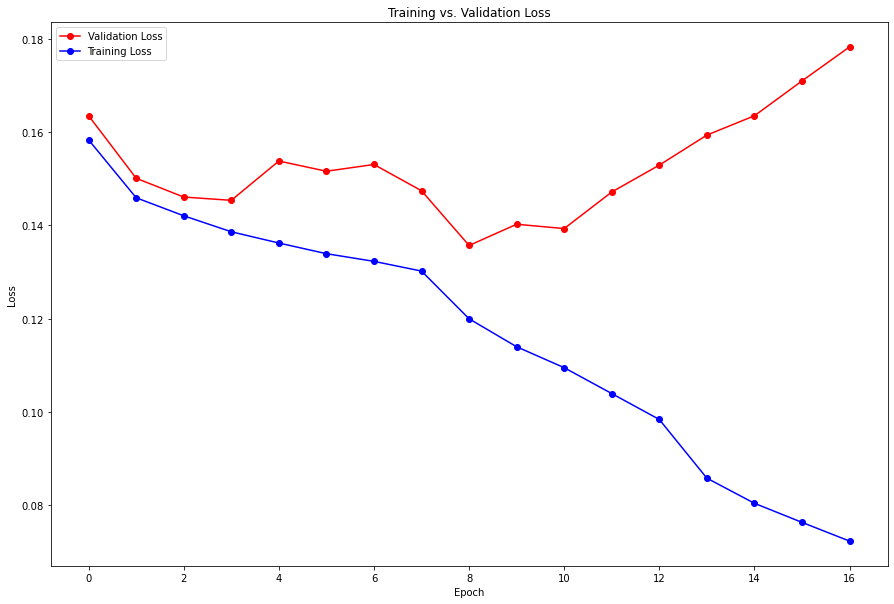

In [43]:
plot_losses(history[m])

### Model 10

In [44]:
# Base Models
base_model_dn169_1 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_dn_1 = Dense(len(labels), activation='sigmoid')(base_model_dn169_1.output)
model_dn_1 = Model(base_model_dn169_1.input, output_layer_dn_1)

for layer in model_dn_1.layers:
    layer.trainable = True

51877672/51877672 [==============================] - 12s 0us/step


In [45]:
model_dn_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [46]:
m = 10 

history[m] = model_dn_1.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-05 23:27:18.752274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - ETA: 0s - loss: 0.3813 - auc_6: 0.2266 - auc_7: 0.6511

2022-06-05 23:35:39.482753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.22448, saving model to ./models/model-10.h5
352/352 [==============================] - 543s 1s/step - loss: 0.3813 - auc_6: 0.2266 - auc_7: 0.6511 - val_loss: 0.2245 - val_auc_6: 0.1683 - val_auc_7: 0.7320 - lr: 0.0010
Epoch 2/40
352/352 [==============================] - ETA: 0s - loss: 0.3322 - auc_6: 0.3436 - auc_7: 0.7347
Epoch 2: val_loss improved from 0.22448 to 0.19454, saving model to ./models/model-10.h5
352/352 [==============================] - 518s 1s/step - loss: 0.3322 - auc_6: 0.3436 - auc_7: 0.7347 - val_loss: 0.1945 - val_auc_6: 0.1682 - val_auc_7: 0.7595 - lr: 0.0010
Epoch 3/40
352/352 [==============================] - ETA: 0s - loss: 0.3148 - auc_6: 0.3958 - auc_7: 0.7693
Epoch 3: val_loss did not improve from 0.19454
352/352 [==============================] - 515s 1s/step - loss: 0.3148 - auc_6: 0.3958 - auc_7: 0.7693 - val_loss: 0.1978 - val_auc_6: 0.2011 - val_auc_7: 0.7650 - lr: 0.0010
Epoch 4/40
352/352 [===============

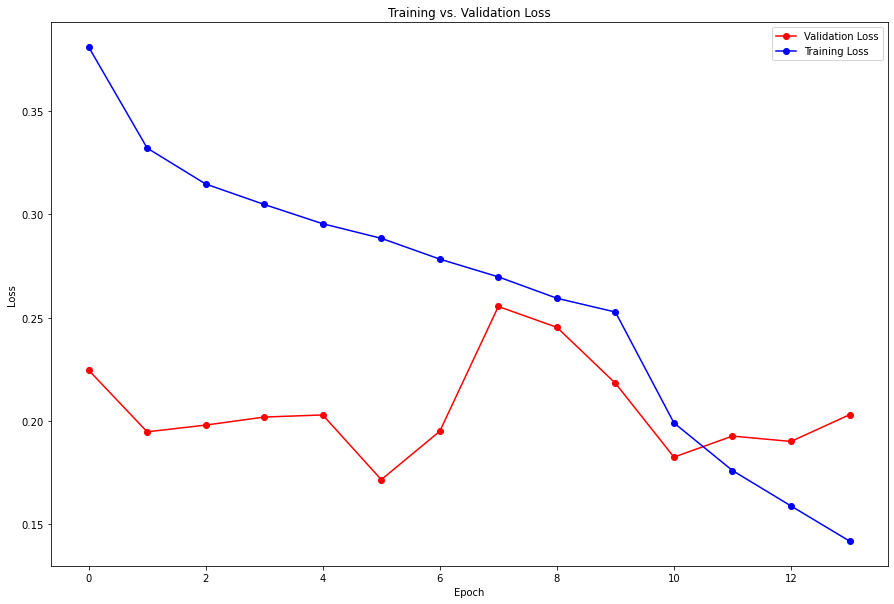

In [47]:
plot_losses(history[m])

### Model 11

In [15]:
# Base Models
base_model_dn169_2 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_dn_2 = Dense(len(labels), activation='sigmoid')(base_model_dn169_2.output)
model_dn_2 = Model(base_model_dn169_2.input, output_layer_dn_2)

for layer in model_dn_2.layers:
    layer.trainable = True

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-06 07:32:03.563953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-06 07:32:03.564097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model_dn_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [17]:
m = 11

history[m] = model_dn_2.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-06 07:32:11.082935: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-06 07:32:17.164999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.1824 - auc: 0.0704 - auc_1: 0.6026

2022-06-06 07:39:38.932221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.16696, saving model to ./models/model-11.h5
313/313 [==============================] - 482s 1s/step - loss: 0.1824 - auc: 0.0704 - auc_1: 0.6026 - val_loss: 0.1670 - val_auc: 0.0958 - val_auc_1: 0.6686 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.1572 - auc: 0.0951 - auc_1: 0.6633
Epoch 2: val_loss improved from 0.16696 to 0.15691, saving model to ./models/model-11.h5
313/313 [==============================] - 465s 1s/step - loss: 0.1572 - auc: 0.0951 - auc_1: 0.6633 - val_loss: 0.1569 - val_auc: 0.1110 - val_auc_1: 0.6853 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1520 - auc: 0.1127 - auc_1: 0.7012
Epoch 3: val_loss improved from 0.15691 to 0.15379, saving model to ./models/model-11.h5
313/313 [==============================] - 464s 1s/step - loss: 0.1520 - auc: 0.1127 - auc_1: 0.7012 - val_loss: 0.1538 - val_auc: 0.1346 - val_auc_1: 0.7538 - lr: 0.0010
Epoch 4/4

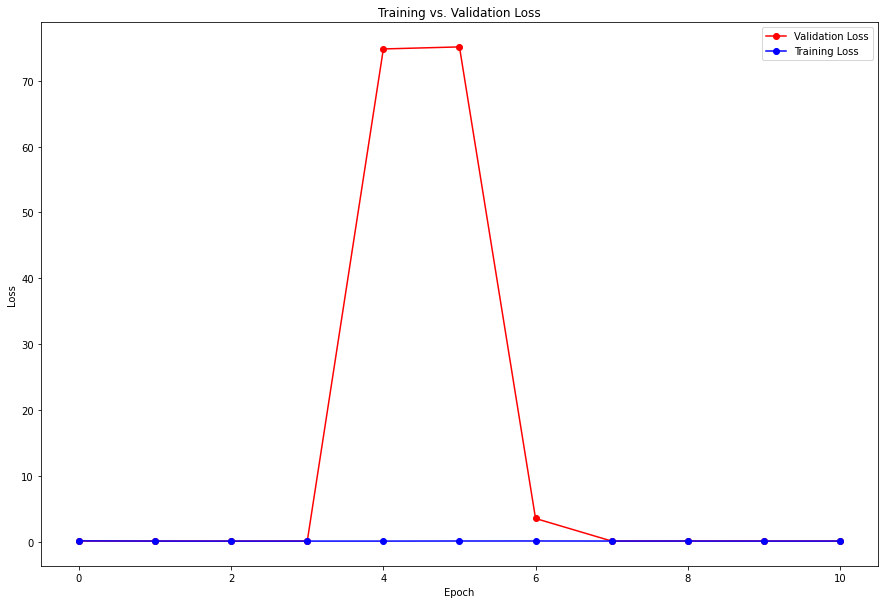

In [18]:
plot_losses(history[m])

### Model 12

In [18]:
# Base Models
base_model_dn169_3 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_dn_3 = Dense(len(labels), activation='sigmoid')(base_model_dn169_3.output)
model_dn_3 = Model(base_model_dn169_3.input, output_layer_dn_3)

for layer in model_dn_3.layers:
    layer.trainable = True

In [19]:
model_dn_3.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [20]:
m = 12

history[m] = model_dn_3.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-06 09:29:40.947910: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-06 09:29:48.159139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 12.6347 - auc_2: 0.0491 - auc_3: 0.5349

2022-06-06 09:37:11.296571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 10.01705, saving model to ./models/model-12.h5
313/313 [==============================] - 487s 2s/step - loss: 12.6347 - auc_2: 0.0491 - auc_3: 0.5349 - val_loss: 10.0171 - val_auc_2: 0.0486 - val_auc_3: 0.5273 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 12.1686 - auc_2: 0.0477 - auc_3: 0.5157
Epoch 2: val_loss did not improve from 10.01705
313/313 [==============================] - 456s 1s/step - loss: 12.1686 - auc_2: 0.0477 - auc_3: 0.5157 - val_loss: 98.1917 - val_auc_2: 0.0447 - val_auc_3: 0.5168 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 11.8772 - auc_2: 0.0500 - auc_3: 0.5292
Epoch 3: val_loss did not improve from 10.01705
313/313 [==============================] - 460s 1s/step - loss: 11.8772 - auc_2: 0.0500 - auc_3: 0.5292 - val_loss: 42.8979 - val_auc_2: 0.0459 - val_auc_3: 0.5182 - lr: 0.0010
Epoch 4/40
313/313 [==============================] - ETA: 0s - lo

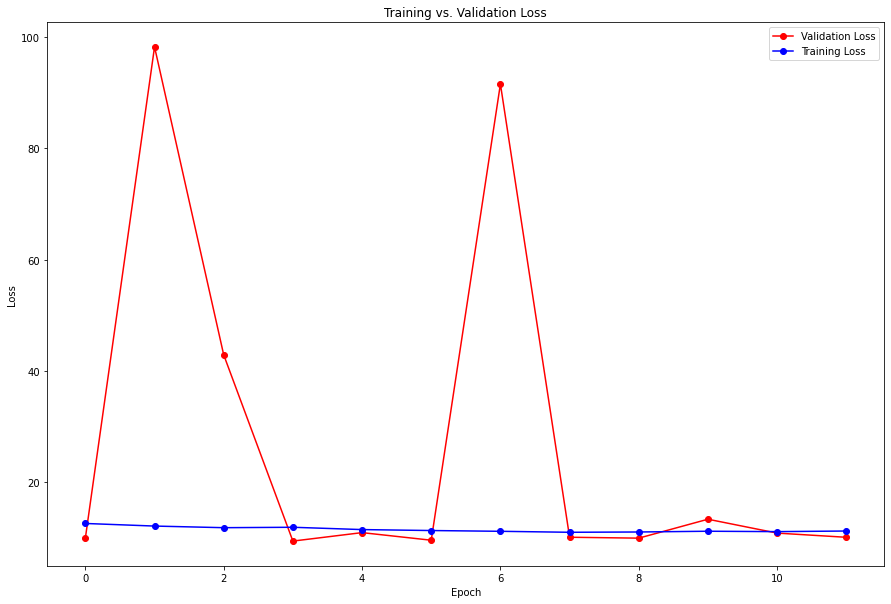

In [21]:
plot_losses(history[m])

## Model Evaluation
---

In [22]:
import csv
from tensorflow.keras.models import load_model

In [23]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):
    
    csv_writer.writerow(['label', 'fpr', 'tpr', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(fpr), fpr, tpr, thresholds))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):

    csv_writer.writerow(['pr', 'rc', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(pr), pr, rc, thresholds))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

In [24]:
for i in np.arange(8, 13):
    model_name = 'model-' + str(i)

    roc_jpg = './results/roc-' + model_name + '.jpg'
    roc_csv = './results/roc-' + model_name + '.csv'
    auroc_csv = './results/auroc-' + model_name + '.csv'
    pr_jpg = './results/pr-' + model_name + '.jpg'
    pr_csv = './results/pr-' + model_name + '.csv'
    aupr_csv= './results/aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    val_gen[i].reset()
    y_true = val_gen[i].labels
    y_pred = model.predict(val_gen[i], batch_size=64, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

2022-06-06 18:34:02.521782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 32s 965ms/step


2022-06-06 18:34:36.392776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 32s 965ms/step


2022-06-06 18:35:11.720153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 36s 1s/step


2022-06-06 18:35:51.072236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 35s 1s/step


2022-06-06 18:36:29.856076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 35s 1s/step


For reference, the model summary table from the beginning of the notebook is copied below.

<br>

__MODEL SUMMARY TABLE__
|  | 8 | 9 | 10 | 11 | 12 |
| --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | Weighted BCE |
| Base Model | Xception | Xception | DenseNet169 | DenseNet169 | DenseNet169 |
| Model Weights | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Stratified Sampling | Random | Stratified Sampling | Random | Random |
| Blocks Frozen | Default | Default | Default | Default | Default |
| Pooling Operation | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D |

* BCE = Binary Cross Entropy

### Area Under ROC Curve

In [29]:
import os

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

results_dir = r'./results/'
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'auroc' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['auroc-model-' + str(x) + '.csv' for x in np.append(np.arange(1, 4), np.arange(8, 13))]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-1.csv,auroc-model-2.csv,auroc-model-3.csv,auroc-model-8.csv,auroc-model-9.csv,auroc-model-10.csv,auroc-model-11.csv,auroc-model-12.csv
Atelectasis,0.702118,0.723808,0.701123,0.720173,0.800596,0.711074,0.743094,0.568979
Cardiomegaly,0.598420,0.784200,0.627678,0.836840,0.836931,0.881103,0.800318,0.605536
Consolidation,0.773982,0.764722,0.798216,0.723360,0.812583,0.752931,0.781799,0.673175
Edema,0.814848,0.883571,0.866344,0.894645,0.889893,0.891859,0.849980,0.718304
Effusion,0.842635,0.839346,0.842761,0.843800,0.900372,0.849912,0.877012,0.599884
Emphysema,0.711032,0.598359,0.753283,0.854298,0.845685,0.751235,0.681810,0.546599
Fibrosis,0.686561,0.679107,0.669490,0.735694,0.769197,0.725520,0.697833,0.607792
Hernia,0.791354,0.945752,0.905692,0.999666,0.949424,0.999165,0.831080,0.845769
Infiltration,0.634464,0.670350,0.615125,0.644691,0.697875,0.627593,0.675921,0.582063
Mass,0.648182,0.732572,0.635370,0.705289,0.849935,0.778637,0.737319,0.483867


In [30]:
print('Average AUROC:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUROC:
auroc-model-1.csv: 0.708466
auroc-model-2.csv: 0.744168
auroc-model-3.csv: 0.715501
auroc-model-8.csv: 0.774693
auroc-model-9.csv: 0.818299
auroc-model-10.csv: 0.772570
auroc-model-11.csv: 0.756000
auroc-model-12.csv: 0.588247


### Area Under PR Curve

In [31]:
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'aupr' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['aupr-model-' + str(x) + '.csv' for x in np.append(np.arange(1, 4), np.arange(8, 13))]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption("SUMMARY - Area Under PR Curve")

File,aupr-model-1.csv,aupr-model-2.csv,aupr-model-3.csv,aupr-model-8.csv,aupr-model-9.csv,aupr-model-10.csv,aupr-model-11.csv,aupr-model-12.csv
Atelectasis,0.163996,0.208453,0.188021,0.239890,0.277921,0.196540,0.217253,0.106303
Cardiomegaly,0.029388,0.099773,0.034887,0.140160,0.167568,0.193063,0.129632,0.054492
Consolidation,0.133307,0.116111,0.121504,0.087582,0.116328,0.099144,0.110378,0.070037
Edema,0.066418,0.154025,0.107548,0.141840,0.158331,0.197444,0.094157,0.063070
Effusion,0.362956,0.462039,0.379477,0.461053,0.590785,0.518745,0.513316,0.135898
Emphysema,0.039089,0.022377,0.075734,0.232207,0.285736,0.230750,0.041919,0.018646
Fibrosis,0.026073,0.027248,0.028627,0.147029,0.054822,0.053929,0.070292,0.022567
Hernia,0.003327,0.034359,0.095646,0.763889,0.092028,0.654762,0.004416,0.016750
Infiltration,0.245505,0.264793,0.244522,0.271535,0.306581,0.276319,0.288910,0.206885
Mass,0.096686,0.130011,0.078362,0.174187,0.319667,0.226485,0.159782,0.042251


In [32]:
print('Average AUPR:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUPR:
aupr-model-1.csv: 0.100980
aupr-model-2.csv: 0.124037
aupr-model-3.csv: 0.116620
aupr-model-8.csv: 0.214980
aupr-model-9.csv: 0.205938
aupr-model-10.csv: 0.222904
aupr-model-11.csv: 0.138267
aupr-model-12.csv: 0.060810


# Conclusions

* The larger pre-trained networks (Xception and DenseNet169) performed better than the baseline VGG16 models (model-1 to model-3)

* Weighted loss function did not perform well, even for a larger model (model-12).

* With respects to number of green cells, both AUROC and AUPR point to model-9 (baseline Xception model with random sampling) as the best performing model. 

* It should also be noted that the models with stratified sampling (model-8 and model-10) perform significantly better on underrepresented labels (Ex: Hernia) when looking at AUPR. This is at the cost of performance on the other labels.

* Comparing the baseline models of Xception (model-9) and DenseNet (model-11), Xception out-performs DenseNet both on average and with respects to number of green cells. However, DenseNet is not far behind. It is also important to note that the Xception model has 22.9M parameters whereas the DenseNet169 model has 14.3M parameters.

* Based on these results, Xception will be the model used to deploy a prototype deep learning model in the next notebook: scaled-prototype.ipynb (e.g. trained on full set of data instead of subset).

The ROC and PR curves for model-9 is shown below.

![image](./results/roc-model-9.jpg)

![image](./results/pr-model-9.jpg)